revised results with the now fully bipartite network

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from itertools import chain

from glob import glob
import os
import seaborn as sns

from collections import defaultdict

In [2]:
%matplotlib inline

---

if no embedding for training data


In [3]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )


def no_convolv(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)

    temp = defaultdict()
    
    for i in range(vecsize):
        temp["f{}_x".format(i)] = "f{}".format(i)

    for i in range(vecsize):
        temp["f{}_y".format(i)] = "f{}".format(i + vecsize)

    reg = reg.rename(columns=temp)
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(K, vecsize):
    for idx in range(K):
        train = pd.read_csv(
            "data/min_hetionet/test/train_{}.tsv".format(idx),
            sep='\t'
        )
        
        holdout = pd.read_csv(
            "data/min_hetionet/test/holdout_{}.tsv".format(idx),
            sep='\t'
        )

        features = pd.read_csv(
            "data/min_hetionet/test/embedding_{}.txt".format(idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )
        
        
        tmp = no_convolv(train, features, vecsize, "inner")

        feat_cols = [
            "f{}".format(i)
            for i in range(2*vecsize)
        ]
        
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = no_convolv(
            holdout.drop("etype", axis=1),
            features, vecsize, "left"
        )
        
        assert len(test) == len(holdout)
        
        # if there are empty ones in the features column,
        # then we didn't generate any embeddings, and therefore
        # need to split those up and treat as zeroes
        # for the others we can predict normally, then join together
        
        regular = test[test["f0"].notnull()].assign(missed = False)
        
        missed = (test[test["f0"].isnull()]
            .assign(
                predval = 0
            )
            .assign(missed = True)
        )
  
        print(regular.shape)
        print(missed.shape)
                
        # add in predictions
        ans = regular.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        ans = ans.append(missed)
        
        assert len(ans) == len(holdout)
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval", "missed"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

need to check that we have the expected embeddings for the concepts

(5993, 133)
(0, 134)
(6476, 133)
(0, 134)
(6538, 133)
(0, 134)
(5421, 133)
(0, 134)
(5758, 133)
(0, 134)


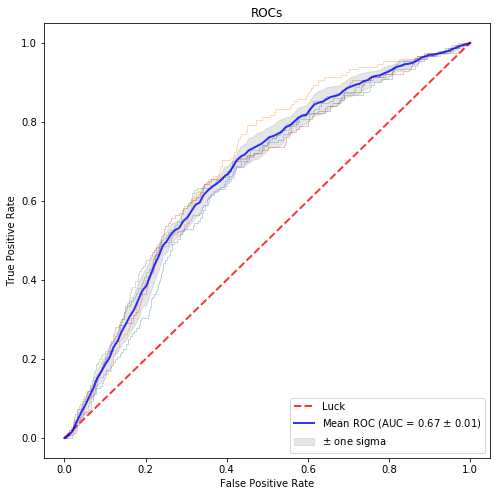

In [5]:
K = 5
vecsize = 64

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 8))

for res in eval_performance(K, vecsize):
    fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0
    auc_val = auc(fpr, tpr)
    aucs.append(auc_val)

    plt.plot(fpr, tpr, lw=1, alpha=0.3)
    
# ---------------    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr, mean_tpr, color='b',
    label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2, alpha=0.8
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr, tprs_lower, tprs_upper, color='grey',
    alpha=0.2, label="$\pm$ one sigma"
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROCs")
          
plt.legend(loc="lower right")
plt.show()

making sure that the adjacency list was bipartite does not seem to have affected the results at all?